### Working with spatial-temporal data

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import skmob
from skmob.preprocessing import detection, clustering

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")

### reading raw data and clean data

In [2]:
events = pd.read_csv("GalapagostortoiseMovementEcology Programme_2009_2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_")
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       #'individual_taxon_canonical_name', 'tag_local_identifier',
       'individual_local_identifier']
tortoise = tortoise[cols].assign()

### working with timezone
 - to calculate time diff, we need to sort by tortoise and then by time
 - to sort by time, we need to use local time, not the UTC because the day concept is associated with the local activities
 - current data has timestamp implicitly in UTC timezone, according to reserach paper, but without time zone attched the data

In [3]:
tortoise.insert(loc = 2, column = "timestamp_UTC",
    value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
)
tortoise.insert(loc = 3, column = "timestamp_local", 
    value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
)

tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)

tortoise.insert(loc = 4, column = "minute_diff", 
    value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
        .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
)

tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date

# we don't really need the day, hour, etc. for now
#tortoise['day'] = tortoise["timestamp_local"].dt.day
#tortoise['hour'] = tortoise["timestamp_local"].dt.hour
#tortoise['weekday'] = tortoise["timestamp_local"].dt.weekday
#tortoise['year_month'] = tortoise["timestamp_local"].apply(lambda t: t.strftime("%Y-%m"))
#tortoise['year_week'] = tortoise["timestamp_local"].apply(lambda t: t.strftime("%Y-%W")) 

In [4]:
tortoise.head(30)

,event_id,timestamp,timestamp_UTC,timestamp_local,minute_diff,location_long,location_lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,individual_local_identifier,year,month,date
1290187,46119277,2010-09-17 17:01:25.998,2010-09-17 17:01:25.998000+00:00,2010-09-17 10:01:25.998000-07:00,0,-90.241889,-0.635366,18,0.00,334.23,181.1,Alison,2010,9,2010-09-17
1290188,46119278,2010-09-17 18:00:58.001,2010-09-17 18:00:58.001000+00:00,2010-09-17 11:00:58.001000-07:00,59,-90.242230,-0.635563,19,0.21,19.01,143.6,Alison,2010,9,2010-09-17
1290189,46119279,2010-09-17 19:00:56.001,2010-09-17 19:00:56.001000+00:00,2010-09-17 12:00:56.001000-07:00,59,-90.242210,-0.635515,22,0.15,359.14,171.4,Alison,2010,9,2010-09-17
1290190,46119280,2010-09-17 20:00:29.000,2010-09-17 20:00:29+00:00,2010-09-17 13:00:29-07:00,59,-90.242227,-0.635356,19,0.75,19.66,156.2,Alison,2010,9,2010-09-17
1290191,46119281,2010-09-17 21:00:56.000,2010-09-17 21:00:56+00:00,2010-09-17 14:00:56-07:00,60,-90.242101,-0.635276,17,0.08,342.75,160.4,Alison,2010,9,2010-09-17
1290192,46119282,2010-09-17 22:01:05.000,2010-09-17 22:01:05+00:00,2010-09-17 15:01:05-07:00,60,-90.242075,-0.635253,17,0.09,245.10,237.1,Alison,2010,9,2010-09-17
1290193,46119283,2010-09-17 23:00:49.999,2010-09-17 23:00:49.999000+00:00,2010-09-17 16:00:49.999000-07:00,59,-90.242144,-0.635304,16,0.16,0.66,165.0,Alison,2010,9,2010-09-17
1290194,46119284,2010-09-18 00:00:55.998,2010-09-18 00:00:55.998000+00:00,2010-09-17 17:00:55.998000-07:00,60,-90.242356,-0.635129,11,0.28,29.49,175.7,Alison,2010,9,2010-09-17
1290195,46119285,2010-09-18 01:01:26.000,2010-09-18 01:01:26+00:00,2010-09-17 18:01:26-07:00,60,-90.242150,-0.635272,9,0.22,322.44,150.7,Alison,2010,9,2010-09-17
1290196,46119286,2010-09-18 11:00:56.000,2010-09-18 11:00:56+00:00,2010-09-18 04:00:56-07:00,599,-90.242106,-0.635292,6,0.18,3.28,159.3,Alison,2010,9,2010-09-18


In [5]:
tortoise.timestamp_local[1].tzinfo, tortoise.timestamp_local[1]

(<DstTzInfo 'US/Pacific' PDT-1 day, 17:00:00 DST>,
 Timestamp('2010-09-23 10:00:49.998000-0700', tz='US/Pacific'))

In [6]:
tortoise.minute_diff.value_counts()

59        636186
60        624193
0         159167
15         90186
600        52443
           ...  
222650         1
782            1
19979          1
177120         1
60117          1
Name: minute_diff, Length: 623, dtype: int64

### we may want to study these tortoises for each group
 - Chelonoidis porteri	-- The western Santa Cruz tortoise is a subspecies of Galápagos tortoise endemic to Santa Cruz Island in the Galápagos. They are found only on the southwestern slopes of the island, with an estimated range of 141 sq. kilometers. 
  - Steve Devine
  - Carolina -- born in 1930?
  - Gnasher
 - Chelonoidis donfaustoi -- Chelonoidis niger donfaustoi, known as the eastern Santa Cruz tortoise, is a subspecies of Galápagos tortoise living on Santa Cruz Island, within the Galápagos. Until 2015, C. n. donfaustoi was classified as part of another subspecies, Chelonoidis porteri.
  - Alison
  - Marilyn
  - Kitty
  - Helber
  - Connor
 - Chelonoidis -- Chelonoidis is a genus of turtles in the tortoise family erected by Leopold Fitzinger in 1835. They are found in South America and the Galápagos Islands, and formerly had a wide distribution in the West Indies. The multiple subspecies of the Galápagos tortoise are among the largest extant terrestrial chelonians. 
  - Christian -- vandenburghi
 - Chelonoidis hoodensis -- The Hood Island giant tortoise is a subspecies of Galápagos tortoise endemic to Española Island in the Galápagos.



In [7]:
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]

In [8]:
temp_df = pd.DataFrame(alison.min()).set_axis(labels = ["min_attr"], axis =1)
temp_df["max_attr"] = alison.max().values
temp_df

,min_attr,max_attr
event_id,46119247,7513055046
timestamp,2010-09-17 17:01:25.998000,2018-10-01 16:00:29.998000
timestamp_UTC,2010-09-17 17:01:25.998000+00:00,2018-10-01 16:00:29.998000+00:00
timestamp_local,2010-09-17 10:01:25.998000-07:00,2018-10-01 09:00:29.998000-07:00
minute_diff,0,150660
location_long,-90.27502,-90.239427
location_lat,-0.656178,-0.629772
eobs_temperature,-2,35
ground_speed,0.0,61.1
heading,0.0,359.79


### computing haversine distances

In [9]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
p1 = [-0.6357607,	-90.2440642]
p2 = [-0.6350828,	-90.2435916]
p1_in_radians = [radians(_) for _ in p1]
p2_in_radians = [radians(_) for _ in p2]
result = haversine_distances([p1_in_radians, p2_in_radians])
(result * 6371000/1000)[0][1]  # multiply by Earth radius to get kilometers


0.09188709683957742

In [10]:
p1, p2, p1_in_radians, p2_in_radians

([-0.6357607, -90.2440642],
 [-0.6350828, -90.2435916],
 [-0.011096117469783912, -1.5750560506711424],
 [-0.011084285882784643, -1.5750478022450976])

In [11]:
from sklearn.metrics.pairwise import haversine_distances
p3 = alison[["location_lat", "location_long"]].apply(lambda x: [radians(_) for _ in x]).iloc[10000]
p4 = alison[["location_lat", "location_long"]].apply(lambda x: [radians(_) for _ in x]).iloc[3400]
haversine_distances(p3.values.reshape(1,-1),p4.values.reshape(1,-1))*6371000/1000

array([[0.0918871]])

In [12]:
p3, p4

(location_lat    -0.011096
 location_long   -1.575056
 Name: 1300671, dtype: float64,
 location_lat    -0.011084
 location_long   -1.575048
 Name: 1293719, dtype: float64)

In [13]:
alison[["location_lat", "location_long"]].apply(lambda x: [radians(_) for _ in x])

,location_lat,location_long
1290187,-0.011089,-1.575018
1290188,-0.011093,-1.575024
1290189,-0.011092,-1.575024
1290190,-0.011089,-1.575024
1290191,-0.011088,-1.575022
...,...,...
1332568,-0.011089,-1.575050
1332569,-0.011089,-1.575051
1332570,-0.011089,-1.575050
1332571,-0.011088,-1.575050


### haversine from scratch

In [14]:
import math
def my_haversine(lat1, lon1, lat2, lon2):
    R = 6371e3 # metres
    phi1 = lat1 * math.pi/180 # φ, λ in radians
    phi2 = lat2 * math.pi/180
    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180
    a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + \
        math.cos(phi1) * math.cos(phi2) * \
        math.sin(delta_lambda/2) * math.sin(delta_lambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c # in metres
    return d

In [15]:
lat1, lon1 = alison[["location_lat", "location_long"]].iloc[10000]
lat2, lon2 = alison[["location_lat", "location_long"]].iloc[3400]
my_haversine(lat1,lon1,lat2,lon2)

91.88709683950982

### haversine by vincenty

In [16]:
from vincenty import vincenty
p5 = (lat1, lon1)
p6 = (lat2, lon2)
vincenty(p5,p6)

0.091576

### by geopy package

In [17]:
from geopy.distance import geodesic as GD
GD(p1,p2).m, GD(p1,p2).km


(91.57615319004627, 0.09157615319004626)

In [18]:
alison[alison["date"] > pd.to_datetime("2015-09-01")].head(30)

,event_id,timestamp,timestamp_UTC,timestamp_local,minute_diff,location_long,location_lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,individual_local_identifier,year,month,date
1317346,1099364575,2015-09-02 11:01:20.001,2015-09-02 11:01:20.001000+00:00,2015-09-02 04:01:20.001000-07:00,600,-90.244298,-0.635955,9,0.36,18.35,175.8,Alison,2015,9,2015-09-02
1317347,1099364576,2015-09-02 12:00:59.999,2015-09-02 12:00:59.999000+00:00,2015-09-02 05:00:59.999000-07:00,59,-90.244237,-0.635957,9,0.42,187.43,171.5,Alison,2015,9,2015-09-02
1317348,1099364577,2015-09-02 13:01:26.000,2015-09-02 13:01:26+00:00,2015-09-02 06:01:26-07:00,60,-90.244282,-0.635923,9,0.36,350.62,173.2,Alison,2015,9,2015-09-02
1317349,1099364578,2015-09-02 14:00:36.998,2015-09-02 14:00:36.998000+00:00,2015-09-02 07:00:36.998000-07:00,59,-90.244236,-0.635967,9,0.58,349.31,156.7,Alison,2015,9,2015-09-02
1317350,1099364579,2015-09-02 15:00:49.999,2015-09-02 15:00:49.999000+00:00,2015-09-02 08:00:49.999000-07:00,60,-90.244336,-0.635931,11,0.03,16.38,168.1,Alison,2015,9,2015-09-02
1317351,1099364580,2015-09-02 16:00:55.998,2015-09-02 16:00:55.998000+00:00,2015-09-02 09:00:55.998000-07:00,60,-90.244424,-0.636002,14,0.29,10.49,165.0,Alison,2015,9,2015-09-02
1317352,1099364581,2015-09-02 17:00:16.000,2015-09-02 17:00:16+00:00,2015-09-02 10:00:16-07:00,59,-90.244366,-0.635865,16,0.02,6.55,132.0,Alison,2015,9,2015-09-02
1317353,1099364582,2015-09-02 18:00:50.000,2015-09-02 18:00:50+00:00,2015-09-02 11:00:50-07:00,60,-90.244318,-0.635899,17,0.10,353.24,154.1,Alison,2015,9,2015-09-02
1317354,1099364583,2015-09-02 19:01:45.000,2015-09-02 19:01:45+00:00,2015-09-02 12:01:45-07:00,60,-90.244517,-0.636036,19,0.58,41.94,91.8,Alison,2015,9,2015-09-02
1317355,1099364584,2015-09-02 20:00:24.999,2015-09-02 20:00:24.999000+00:00,2015-09-02 13:00:24.999000-07:00,58,-90.244419,-0.635883,21,0.35,225.44,161.2,Alison,2015,9,2015-09-02


### trajectory

In [19]:
tortoise_trajectory = skmob.TrajDataFrame(tortoise, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)
print(tortoise_trajectory.head())

         event_id               timestamp                    timestamp_UTC  \
1290187  46119277 2010-09-17 17:01:25.998 2010-09-17 17:01:25.998000+00:00   
1290188  46119278 2010-09-17 18:00:58.001 2010-09-17 18:00:58.001000+00:00   
1290189  46119279 2010-09-17 19:00:56.001 2010-09-17 19:00:56.001000+00:00   
1290190  46119280 2010-09-17 20:00:29.000        2010-09-17 20:00:29+00:00   
1290191  46119281 2010-09-17 21:00:56.000        2010-09-17 21:00:56+00:00   

                                datetime  minute_diff        lng       lat  \
1290187 2010-09-17 10:01:25.998000-07:00            0 -90.241889 -0.635366   
1290188 2010-09-17 11:00:58.001000-07:00           59 -90.242230 -0.635563   
1290189 2010-09-17 12:00:56.001000-07:00           59 -90.242210 -0.635515   
1290190        2010-09-17 13:00:29-07:00           59 -90.242227 -0.635356   
1290191        2010-09-17 14:00:56-07:00           60 -90.242101 -0.635276   

         eobs_temperature  ground_speed  heading  height_above

 - maybe easier to work with a single tortoise, let's do Alison
 - note that in trajectory data structure, the individual_local_identifier was changed into "uid" when we created the trajectory from original dataframe

In [20]:
alison_trajectory = tortoise_trajectory.query("uid == 'Alison'")
alison_trajectory

,event_id,timestamp,timestamp_UTC,datetime,minute_diff,lng,lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,uid,year,month,date
1290187,46119277,2010-09-17 17:01:25.998,2010-09-17 17:01:25.998000+00:00,2010-09-17 10:01:25.998000-07:00,0,-90.241889,-0.635366,18,0.00,334.23,181.1,Alison,2010,9,2010-09-17
1290188,46119278,2010-09-17 18:00:58.001,2010-09-17 18:00:58.001000+00:00,2010-09-17 11:00:58.001000-07:00,59,-90.242230,-0.635563,19,0.21,19.01,143.6,Alison,2010,9,2010-09-17
1290189,46119279,2010-09-17 19:00:56.001,2010-09-17 19:00:56.001000+00:00,2010-09-17 12:00:56.001000-07:00,59,-90.242210,-0.635515,22,0.15,359.14,171.4,Alison,2010,9,2010-09-17
1290190,46119280,2010-09-17 20:00:29.000,2010-09-17 20:00:29+00:00,2010-09-17 13:00:29-07:00,59,-90.242227,-0.635356,19,0.75,19.66,156.2,Alison,2010,9,2010-09-17
1290191,46119281,2010-09-17 21:00:56.000,2010-09-17 21:00:56+00:00,2010-09-17 14:00:56-07:00,60,-90.242101,-0.635276,17,0.08,342.75,160.4,Alison,2010,9,2010-09-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332568,7513055042,2018-10-01 12:00:24.999,2018-10-01 12:00:24.999000+00:00,2018-10-01 05:00:24.999000-07:00,59,-90.243718,-0.635341,8,0.20,12.45,162.8,Alison,2018,10,2018-10-01
1332569,7513055043,2018-10-01 13:00:30.001,2018-10-01 13:00:30.001000+00:00,2018-10-01 06:00:30.001000-07:00,60,-90.243748,-0.635348,7,0.17,16.38,166.0,Alison,2018,10,2018-10-01
1332570,7513055044,2018-10-01 14:00:55.999,2018-10-01 14:00:55.999000+00:00,2018-10-01 07:00:55.999000-07:00,60,-90.243731,-0.635363,9,0.25,16.38,168.2,Alison,2018,10,2018-10-01
1332571,7513055045,2018-10-01 15:00:28.001,2018-10-01 15:00:28.001000+00:00,2018-10-01 08:00:28.001000-07:00,59,-90.243696,-0.635290,10,2.16,217.58,184.6,Alison,2018,10,2018-10-01


In [21]:
from skmob.measures.individual import radius_of_gyration
tortoise_radius_gyration = radius_of_gyration(tortoise_trajectory)
tortoise_radius_gyration

100%|██████████| 96/96 [00:07<00:00, 12.24it/s]


,uid,radius_of_gyration
0,Alison,1.498891
1,Andrea,2.287264
2,Andres,0.036833
3,Anne,1.506432
4,Bill,0.257950
5,Birgit,1.724073
6,Carolina,2.910251
7,Charles,0.208723
8,Chica,0.169185
9,Chrissie,1.433080


 - compute radius of gyration by day, let's do Alison only

In [22]:
radius_of_gyration(alison_trajectory[alison_trajectory["date"] == pd.to_datetime('2010-09-17')])["radius_of_gyration"][0]

100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


0.01951637960295725

In [23]:
from skmob.measures.individual import radius_of_gyration
alison_rog = []
date_list = []
for date in alison.date.unique():
    date_list.append(date)
    rog = radius_of_gyration(alison_trajectory[alison_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]
    alison_rog.append(rog)

In [24]:
alison.date.nunique(), len(alison_rog)

(2827, 2827)

In [25]:
alison_radius_gyration = pd.DataFrame(data = {"date": date_list, "rog":alison_rog})
alison_radius_gyration

,date,rog
0,2010-09-17,0.019516
1,2010-09-18,0.030361
2,2010-09-19,0.016238
3,2010-09-20,0.022284
4,2010-09-21,0.018266
...,...,...
2822,2018-09-27,0.013900
2823,2018-09-28,0.022776
2824,2018-09-29,0.049017
2825,2018-09-30,0.010716


<Axes: xlabel='date', ylabel='rog'>

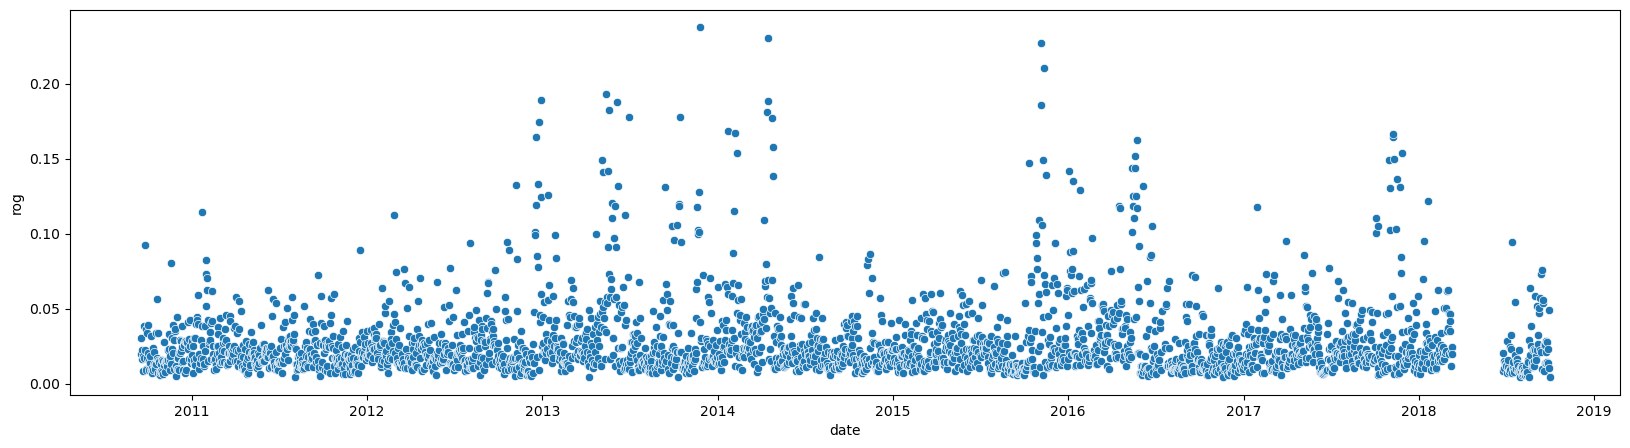

In [26]:
plt.figure(figsize = (20,5))
sns.scatterplot(data = alison_radius_gyration, x="date", y="rog")

### tesselation as RoI

In [27]:
from skmob.tessellation import tilers
from skmob.preprocessing import filtering
tessellation = tilers.tiler.get("h3_tessellation", base_shape="isla santa cruz", meters=500)
type(tessellation["geometry"][0])

shapely.geometry.polygon.Polygon

In [28]:
tessellation.iloc[0], tessellation.iloc[3]

(geometry    POLYGON ((-90.28433368421148 -0.53766350467471...
 H3_INDEX                                   614395641939886079
 tile_ID                                                     0
 Name: 0, dtype: object,
 geometry    POLYGON ((-90.42829863449863 -0.67058300774366...
 H3_INDEX                                   614395806312562687
 tile_ID                                                     3
 Name: 3, dtype: object)

In [29]:
tessellation.iloc[0].geometry.hausdorff_distance(tessellation.iloc[3].geometry)

0.19594646372488556

### mapping trajectory into tesselation

In [30]:
type(tessellation.tile_ID[1])

str

In [31]:
tortoise_trajectory_mapping = tortoise_trajectory.mapping(tessellation)
tortoise_trajectory_mapping.shape, tortoise_trajectory_mapping.drop_duplicates(subset=['date','tile_ID']).shape

((1795892, 16), (53968, 16))

 - reduced to 3% of events

In [32]:
alison_trajectory_mapping = tortoise_trajectory_mapping.query("uid == 'Alison'")
alison_trajectory_mapping.shape

(40003, 16)

In [33]:
alison_trajectory_mapping.drop_duplicates(subset=["date", "tile_ID"]).shape

(3254, 16)

 - reduced to 8%

In [34]:
alison_trajectory_mapping.drop_duplicates(subset=["date", "tile_ID"]).head(30)

,event_id,timestamp,timestamp_UTC,datetime,minute_diff,lng,lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,uid,year,month,date,tile_ID
1290187,46119277,2010-09-17 17:01:25.998,2010-09-17 17:01:25.998000+00:00,2010-09-17 10:01:25.998000-07:00,0,-90.241889,-0.635366,18,0.00,334.23,181.1,Alison,2010,9,2010-09-17,221
1290196,46119286,2010-09-18 11:00:56.000,2010-09-18 11:00:56+00:00,2010-09-18 04:00:56-07:00,599,-90.242106,-0.635292,6,0.18,3.28,159.3,Alison,2010,9,2010-09-18,221
1290211,46119301,2010-09-19 11:01:14.001,2010-09-19 11:01:14.001000+00:00,2010-09-19 04:01:14.001000-07:00,600,-90.242532,-0.635550,6,2.02,175.64,180.1,Alison,2010,9,2010-09-19,221
1290226,46119316,2010-09-20 11:01:19.999,2010-09-20 11:01:19.999000+00:00,2010-09-20 04:01:19.999000-07:00,599,-90.242616,-0.635280,6,1.54,172.36,137.3,Alison,2010,9,2010-09-20,221
1290241,46119332,2010-09-21 11:00:43.999,2010-09-21 11:00:43.999000+00:00,2010-09-21 04:00:43.999000-07:00,599,-90.242572,-0.635399,6,0.23,330.96,156.2,Alison,2010,9,2010-09-21,221
1290256,46119347,2010-09-22 11:01:14.001,2010-09-22 11:01:14.001000+00:00,2010-09-22 04:01:14.001000-07:00,600,-90.242538,-0.635429,6,0.40,352.58,153.4,Alison,2010,9,2010-09-22,221
1290271,46119362,2010-09-23 11:01:13.998,2010-09-23 11:01:13.998000+00:00,2010-09-23 04:01:13.998000-07:00,599,-90.242559,-0.635432,5,0.24,341.44,163.5,Alison,2010,9,2010-09-23,221
1290286,46119376,2010-09-24 11:00:56.000,2010-09-24 11:00:56+00:00,2010-09-24 04:00:56-07:00,599,-90.242566,-0.635424,5,0.50,342.10,162.8,Alison,2010,9,2010-09-24,221
1290301,46119390,2010-09-25 11:01:14.999,2010-09-25 11:01:14.999000+00:00,2010-09-25 04:01:14.999000-07:00,600,-90.242567,-0.635439,5,0.01,338.82,162.6,Alison,2010,9,2010-09-25,221
1290317,46119405,2010-09-26 12:00:56.000,2010-09-26 12:00:56+00:00,2010-09-26 05:00:56-07:00,660,-90.242099,-0.635237,4,0.17,302.78,148.7,Alison,2010,9,2010-09-26,221


In [35]:
tessellation.query("tile_ID == '221' or tile_ID == '411'")

,geometry,H3_INDEX,tile_ID
221,"POLYGON ((-90.24372 -0.62648, -90.24802 -0.629...",614395654040453119,221
411,"POLYGON ((-90.23886 -0.63378, -90.24315 -0.636...",614395654042550271,411


In [36]:
tessellation.iloc[221].geometry.hausdorff_distance(tessellation.iloc[411].geometry)

0.00876945352913159

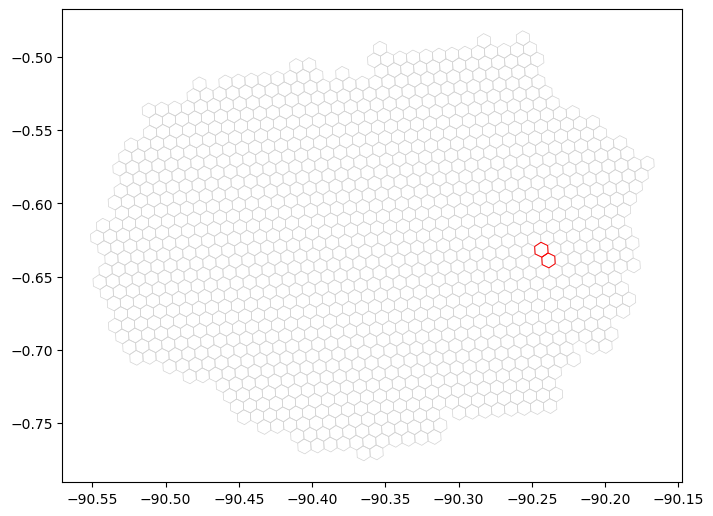

In [37]:
fig, ax = plt.subplots(figsize = (8,8))
tessellation["geometry"].boundary.plot(color="lightgrey", ax=ax, linewidth=0.5)
tessellation.query("tile_ID == '221' or tile_ID =='411'")["geometry"].boundary.plot(color="r", ax=ax,linewidth=0.7)

#plt.annotate(s=tessellation["tile_ID"], text=tessellation["tile_ID"], xy=tessellation.geometry[1])
#tessellation["geometry"].boundary.plot()
plt.show()

### stay locaiton: minutes_for_a_stop = 400, 6.8 hours that the tortoise stayed in the stay location


In [38]:
tortoise_stay_location = detection.stay_locations(tortoise_trajectory, stop_radius_factor=0.2, minutes_for_a_stop=400,
    spatial_radius_km=0.2, leaving_time=True)

In [39]:
tortoise_stay_location

,event_id,timestamp,timestamp_UTC,datetime,minute_diff,lng,lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,uid,year,month,date,leaving_datetime
0,46120122,2010-11-13 17:00:13.999,2010-11-13 17:00:13.999000+00:00,2010-09-17 10:01:25.998000-07:00,59,-90.242532,-0.635400,14,0.20,355.21,182.5,Alison,2010,11,2010-11-13,2010-11-13 10:00:40-08:00
1,46120221,2010-11-20 12:00:33.999,2010-11-20 12:00:33.999000+00:00,2010-11-13 10:00:40-08:00,59,-90.243338,-0.635317,5,0.36,340.13,137.5,Alison,2010,11,2010-11-20,2010-11-20 05:00:27-08:00
2,46120252,2010-11-22 13:00:50.000,2010-11-22 13:00:50+00:00,2010-11-20 05:00:27-08:00,59,-90.242979,-0.635375,5,0.21,355.21,164.4,Alison,2010,11,2010-11-22,2010-11-22 06:00:43.998000-08:00
3,46121014,2011-01-12 12:00:50.000,2011-01-12 12:00:50+00:00,2010-11-22 06:00:43.998000-08:00,59,-90.243354,-0.635371,10,0.38,354.55,166.1,Alison,2011,1,2011-01-12,2011-01-12 05:00:55.998000-08:00
4,46121058,2011-01-15 13:00:27.000,2011-01-15 13:00:27+00:00,2011-01-12 05:00:55.998000-08:00,59,-90.242196,-0.635285,10,0.25,336.20,158.3,Alison,2011,1,2011-01-15,2011-01-15 06:00:14-08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19680,1751003388,2016-03-13 14:00:50.001,2016-03-13 14:00:50.001000+00:00,2016-03-07 05:00:25.998000-08:00,60,-89.682304,-1.372971,19,0.19,358.48,135.8,Zelfa,2016,3,2016-03-13,2016-03-13 08:01:30-07:00
19681,1751003478,2016-03-19 14:00:49.999,2016-03-19 14:00:49.999000+00:00,2016-03-13 08:01:30-07:00,60,-89.682519,-1.374075,20,0.22,0.00,145.7,Zelfa,2016,3,2016-03-19,2016-03-19 08:00:25.998000-07:00
19682,1751004227,2016-05-08 13:00:27.998,2016-05-08 13:00:27.998000+00:00,2016-03-19 08:00:25.998000-07:00,60,-89.682553,-1.371500,11,0.19,91.75,124.9,Zelfa,2016,5,2016-05-08,2016-05-08 07:00:43.998000-07:00
19683,1751004471,2016-05-24 17:00:56.000,2016-05-24 17:00:56+00:00,2016-05-08 07:00:43.998000-07:00,60,-89.682791,-1.373416,17,0.10,0.00,134.1,Zelfa,2016,5,2016-05-24,2016-05-24 11:00:52.999000-07:00


In [40]:
# cluster stops
tortoise_stay_clusters = clustering.cluster(tortoise_stay_location, cluster_radius_km=0.2, min_samples=1)
print(tortoise_stay_clusters.head())


   event_id               timestamp                    timestamp_UTC  \
0  46120122 2010-11-13 17:00:13.999 2010-11-13 17:00:13.999000+00:00   
1  46120221 2010-11-20 12:00:33.999 2010-11-20 12:00:33.999000+00:00   
2  46120252 2010-11-22 13:00:50.000        2010-11-22 13:00:50+00:00   
3  46121014 2011-01-12 12:00:50.000        2011-01-12 12:00:50+00:00   
4  46121058 2011-01-15 13:00:27.000        2011-01-15 13:00:27+00:00   

                          datetime  minute_diff        lng       lat  \
0 2010-09-17 10:01:25.998000-07:00           59 -90.242532 -0.635400   
1        2010-11-13 10:00:40-08:00           59 -90.243338 -0.635317   
2        2010-11-20 05:00:27-08:00           59 -90.242979 -0.635375   
3 2010-11-22 06:00:43.998000-08:00           59 -90.243354 -0.635371   
4 2011-01-12 05:00:55.998000-08:00           59 -90.242196 -0.635285   

   eobs_temperature  ground_speed  heading  height_above_ellipsoid     uid  \
0                14          0.20   355.21              

In [41]:
tortoise_stay_clusters.cluster.value_counts()

0     13030
1      2438
2      1184
3       593
4       394
5       293
6       228
7       191
8       168
9       141
10      115
11      103
12       76
13       71
14       61
15       53
16       47
17       43
18       41
19       33
21       31
20       31
22       25
23       21
24       19
26       18
25       18
27       17
28       14
29       13
30       13
31       12
32       10
33        9
34        9
35        8
36        8
37        7
39        6
38        6
43        6
40        6
42        6
41        6
44        5
45        4
46        4
47        4
48        3
55        2
58        2
57        2
56        2
51        2
54        2
53        2
52        2
60        2
50        2
59        2
64        2
61        2
62        2
63        2
65        2
66        2
67        2
49        2
68        1
69        1
70        1
71        1
72        1
Name: cluster, dtype: int64

In [42]:
alison_stay_location = tortoise_stay_location.query("uid == 'Alison'")
alison_stay_location[(alison_stay_location["datetime"] < pd.Timestamp('2016-05-31').tz_localize(tz='US/Pacific')) & \
    (alison_stay_location['datetime'] > pd.Timestamp('2015-05-31').tz_localize(tz = 'US/Pacific'))]

,event_id,timestamp,timestamp_UTC,datetime,minute_diff,lng,lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,uid,year,month,date,leaving_datetime
164,917036605,2015-07-03 15:00:27.000,2015-07-03 15:00:27+00:00,2015-06-20 07:00:13.001000-07:00,59,-90.242278,-0.635562,15,0.42,0.66,175.7,Alison,2015,7,2015-07-03,2015-07-03 09:00:50.998000-07:00
165,991089390,2015-08-19 16:00:22.998,2015-08-19 16:00:22.998000+00:00,2015-07-03 09:00:50.998000-07:00,60,-90.243278,-0.635550,19,0.09,11.14,40.4,Alison,2015,8,2015-08-19,2015-08-19 10:00:57.001000-07:00
166,991089492,2015-08-26 13:00:34.000,2015-08-26 13:00:34+00:00,2015-08-19 10:00:57.001000-07:00,59,-90.241567,-0.636421,8,0.10,332.92,169.8,Alison,2015,8,2015-08-26,2015-08-26 07:00:44-07:00
167,1099249203,2015-10-03 17:01:10.001,2015-10-03 17:01:10.001000+00:00,2015-08-26 07:00:44-07:00,59,-90.244269,-0.635823,23,0.49,37.36,166.3,Alison,2015,10,2015-10-03,2015-10-03 11:00:43.999000-07:00
168,1099249338,2015-10-12 17:00:56.000,2015-10-12 17:00:56+00:00,2015-10-03 11:00:43.999000-07:00,59,-90.245389,-0.636665,21,0.22,34.73,174.6,Alison,2015,10,2015-10-12,2015-10-12 11:00:55.999000-07:00
169,1099249351,2015-10-13 15:00:13.998,2015-10-13 15:00:13.998000+00:00,2015-10-12 11:00:55.999000-07:00,59,-90.247639,-0.634068,14,0.46,9.83,175.5,Alison,2015,10,2015-10-13,2015-10-13 09:01:37.998000-07:00
170,1099249412,2015-10-17 16:01:14.998,2015-10-17 16:01:14.998000+00:00,2015-10-13 09:01:37.998000-07:00,60,-90.248289,-0.634437,19,2.54,226.10,133.3,Alison,2015,10,2015-10-17,2015-10-17 10:00:57.001000-07:00
171,1099249546,2015-10-26 15:00:40.999,2015-10-26 15:00:40.999000+00:00,2015-10-17 10:00:57.001000-07:00,60,-90.250388,-0.632992,13,0.24,3.28,202.4,Alison,2015,10,2015-10-26,2015-10-26 09:01:19.999000-07:00
172,1099249564,2015-10-27 18:00:49.998,2015-10-27 18:00:49.998000+00:00,2015-10-26 09:01:19.999000-07:00,60,-90.252036,-0.631418,28,0.24,3.93,192.9,Alison,2015,10,2015-10-27,2015-10-27 12:00:54.999000-07:00
173,1099249589,2015-10-29 13:00:19.999,2015-10-29 13:00:19.999000+00:00,2015-10-27 12:00:54.999000-07:00,59,-90.254425,-0.632729,10,0.42,343.41,206.4,Alison,2015,10,2015-10-29,2015-10-29 07:00:50.999000-07:00


<Axes: xlabel='datetime'>

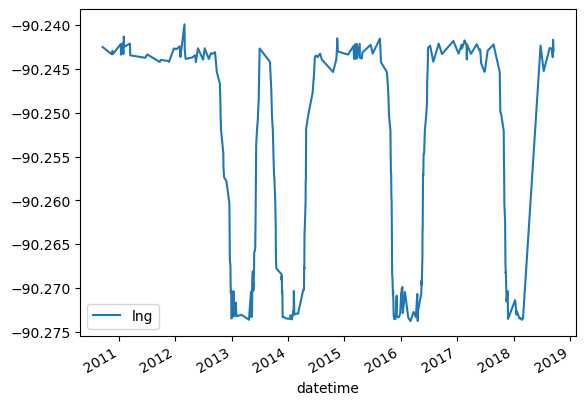

In [43]:
alison_stay_location.plot(x="datetime", y ="lng")

In [44]:
tortoise_stay_clusters.query("uid == 'Alison'")

,event_id,timestamp,timestamp_UTC,datetime,minute_diff,lng,lat,eobs_temperature,ground_speed,heading,height_above_ellipsoid,uid,year,month,date,leaving_datetime,cluster
0,46120122,2010-11-13 17:00:13.999,2010-11-13 17:00:13.999000+00:00,2010-09-17 10:01:25.998000-07:00,59,-90.242532,-0.635400,14,0.20,355.21,182.5,Alison,2010,11,2010-11-13,2010-11-13 10:00:40-08:00,1
1,46120221,2010-11-20 12:00:33.999,2010-11-20 12:00:33.999000+00:00,2010-11-13 10:00:40-08:00,59,-90.243338,-0.635317,5,0.36,340.13,137.5,Alison,2010,11,2010-11-20,2010-11-20 05:00:27-08:00,1
2,46120252,2010-11-22 13:00:50.000,2010-11-22 13:00:50+00:00,2010-11-20 05:00:27-08:00,59,-90.242979,-0.635375,5,0.21,355.21,164.4,Alison,2010,11,2010-11-22,2010-11-22 06:00:43.998000-08:00,1
3,46121014,2011-01-12 12:00:50.000,2011-01-12 12:00:50+00:00,2010-11-22 06:00:43.998000-08:00,59,-90.243354,-0.635371,10,0.38,354.55,166.1,Alison,2011,1,2011-01-12,2011-01-12 05:00:55.998000-08:00,1
4,46121058,2011-01-15 13:00:27.000,2011-01-15 13:00:27+00:00,2011-01-12 05:00:55.998000-08:00,59,-90.242196,-0.635285,10,0.25,336.20,158.3,Alison,2011,1,2011-01-15,2011-01-15 06:00:14-08:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,7338385931,2018-09-06 23:00:56.000,2018-09-06 23:00:56+00:00,2018-09-05 10:00:26-07:00,59,-90.242714,-0.635734,10,0.14,124.52,200.4,Alison,2018,9,2018-09-06,2018-09-06 17:00:16.001000-07:00,1
291,7338386015,2018-09-12 17:00:56.999,2018-09-12 17:00:56.999000+00:00,2018-09-06 17:00:16.001000-07:00,60,-90.242893,-0.635729,22,0.25,18.35,165.5,Alison,2018,9,2018-09-12,2018-09-12 11:00:40.999000-07:00,1
292,7456690859,2018-09-14 14:00:52.999,2018-09-14 14:00:52.999000+00:00,2018-09-12 11:00:40.999000-07:00,60,-90.243685,-0.635802,8,0.57,11.14,155.2,Alison,2018,9,2018-09-14,2018-09-14 08:00:14.998000-07:00,1
293,7456690906,2018-09-17 16:00:43.999,2018-09-17 16:00:43.999000+00:00,2018-09-14 08:00:14.998000-07:00,60,-90.241715,-0.636247,17,0.14,351.93,169.4,Alison,2018,9,2018-09-17,2018-09-17 10:00:20.999000-07:00,1


<Axes: title={'center': 'user Alison'}>

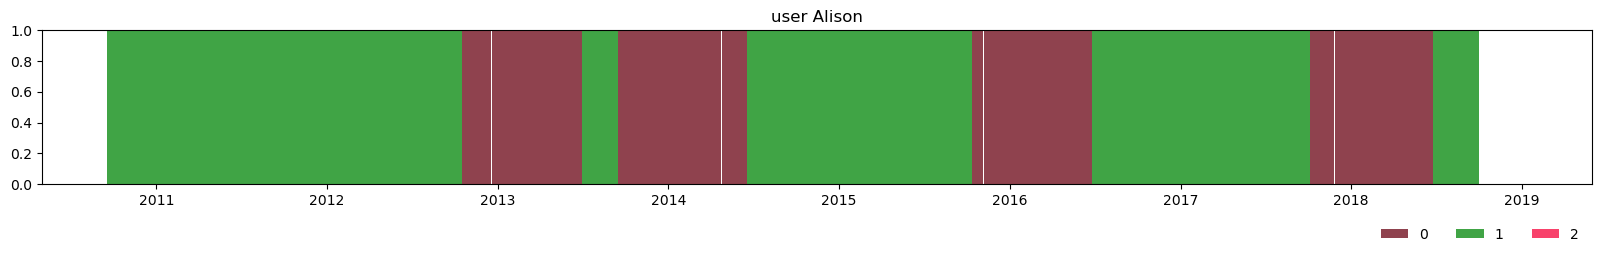

In [45]:
# plot the diary of one individual
user = "Alison"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_clusters.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)


<Axes: xlabel='timestamp_local', ylabel='location_long'>

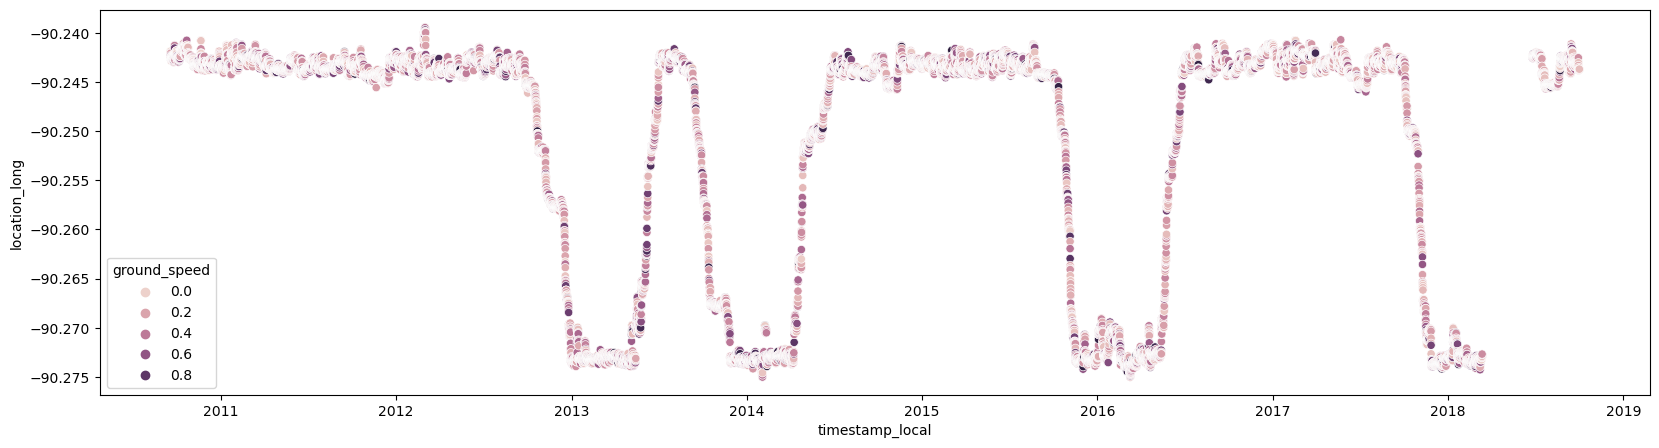

In [46]:
plt.figure(figsize = (20,5))
alison = tortoise.query("individual_local_identifier == 'Alison' and ground_speed <1") # ground_speed unit is meters per second
sns.scatterplot(alison, x = "timestamp_local", y="location_long", hue="ground_speed")


<Axes: xlabel='timestamp_local', ylabel='location_lat'>

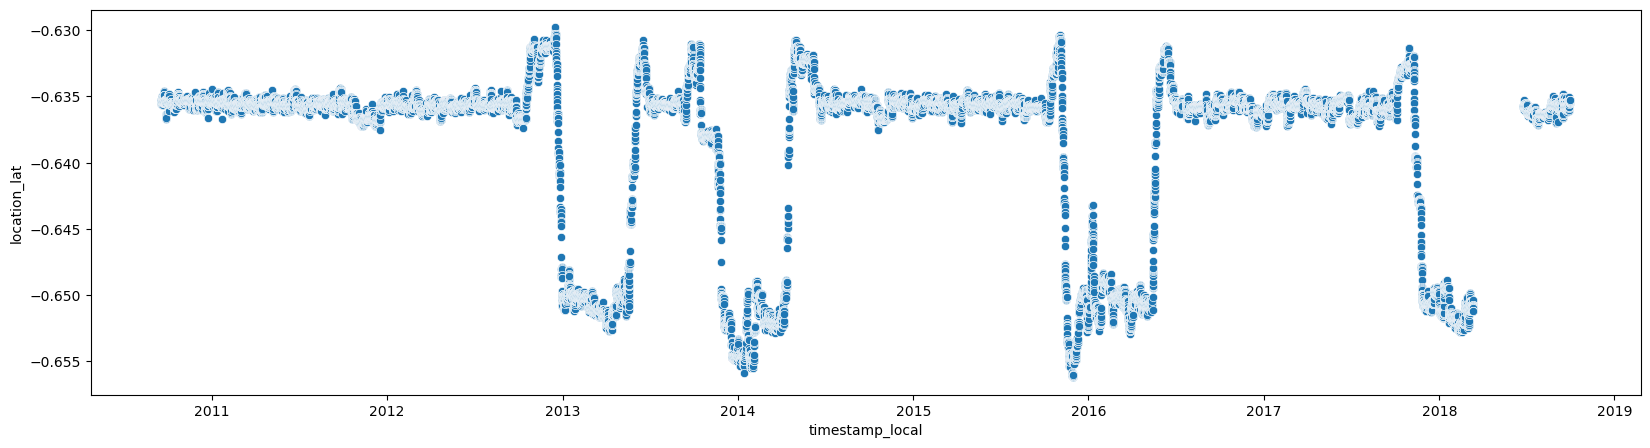

In [47]:
plt.figure(figsize = (20,5))
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
sns.scatterplot(alison, x = "timestamp_local", y="location_lat")

<Axes: title={'center': 'user Christian'}>

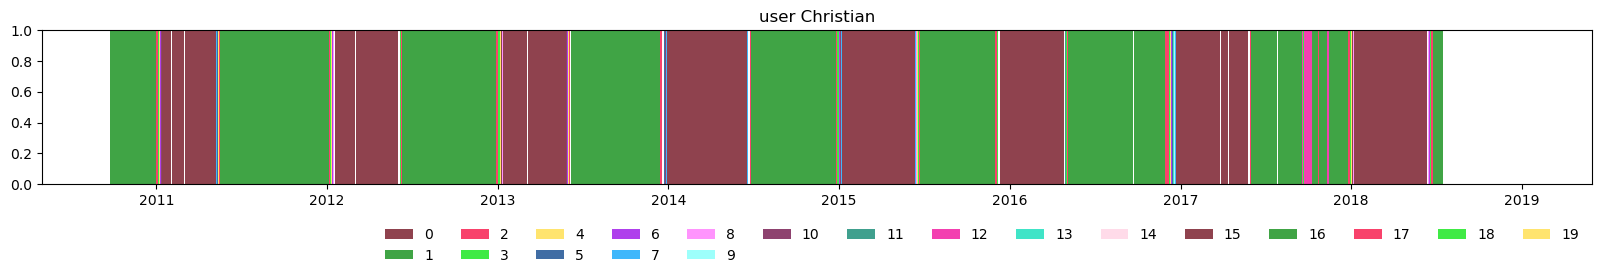

In [48]:
user = "Christian"
start_datetime = pd.to_datetime('2010-05-01 030000').tz_localize(tz='US/Pacific')
end_datetime = pd.to_datetime('2019-05-31 030000').tz_localize(tz='US/Pacific')
tortoise_stay_clusters.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime,legend=True)

In [49]:
def invidual_lat_long(name, lat_long):
    plt.figure(figsize = (20,5))
    df_name = tortoise[tortoise["individual_local_identifier"] == name]
    sns.scatterplot(df_name, x = "timestamp", y=lat_long)


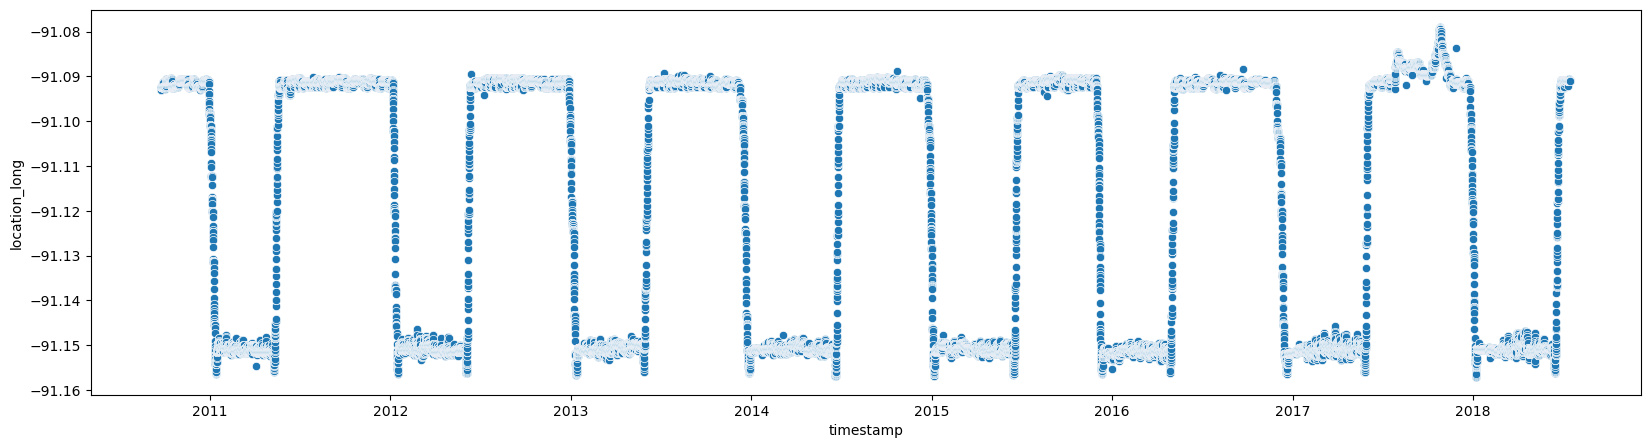

In [50]:
invidual_lat_long("Christian", "location_long")

In [51]:
temp_df = tortoise.groupby("individual_local_identifier").agg(max_time = ('timestamp', max), min_time = ('timestamp', min) )
temp_df["length"] = (temp_df.max_time - temp_df.min_time)
temp_df.sort_values(by="length", ascending=False)

,max_time,min_time,length
individual_local_identifier,,,
Sandra,2018-10-01 16:00:06.000,2010-05-28 17:00:21.998,3047 days 22:59:44.002000
Kitty,2018-10-01 16:00:29.998,2010-09-17 16:01:24.999,2935 days 23:59:04.999000
Alison,2018-10-01 16:00:29.998,2010-09-17 17:01:25.998,2935 days 22:59:04
Marilyn,2018-10-01 16:00:13.998,2010-09-17 18:01:31.998,2935 days 21:58:42
Steve Devine,2018-07-27 13:00:47.001,2010-09-20 22:01:25.001,2866 days 14:59:22
Greg,2018-07-22 15:00:25.998,2010-09-23 21:00:43.998,2858 days 17:59:42
Anne,2018-07-21 22:00:16.999,2010-09-23 22:00:51.001,2857 days 23:59:25.998000
Martin,2018-07-21 21:00:20.001,2010-09-23 22:00:58.999,2857 days 22:59:21.002000
Sparkey,2018-07-19 19:00:44.999,2010-09-23 17:00:49.998,2856 days 01:59:55.001000


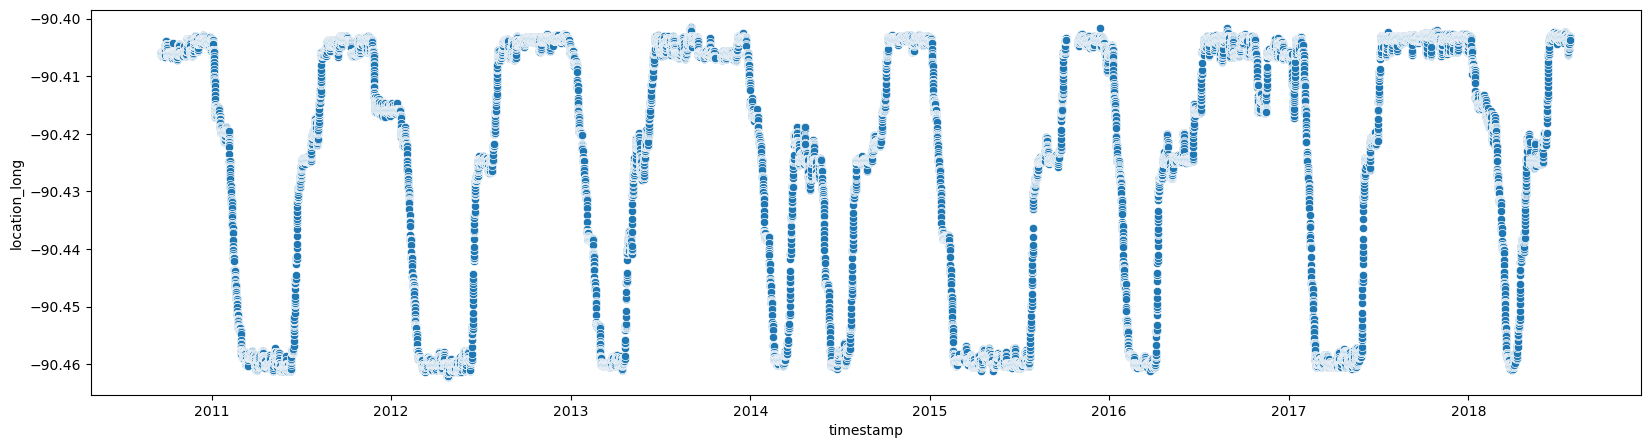

In [52]:
invidual_lat_long("Steve Devine", "location_long")

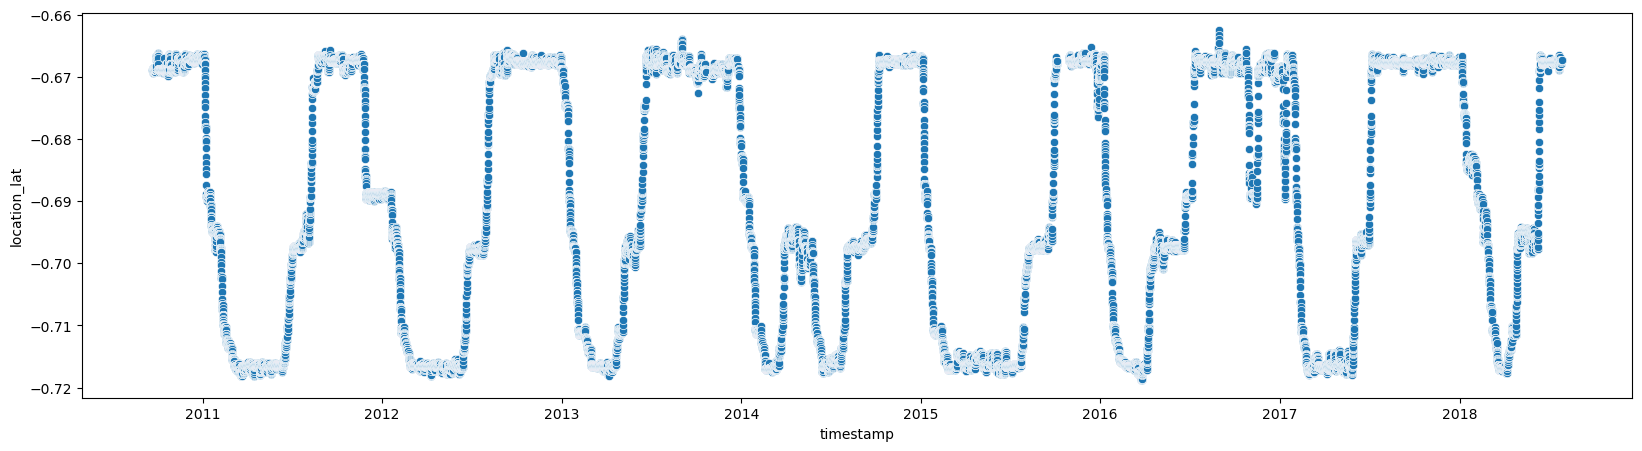

In [53]:
invidual_lat_long("Steve Devine", "location_lat")

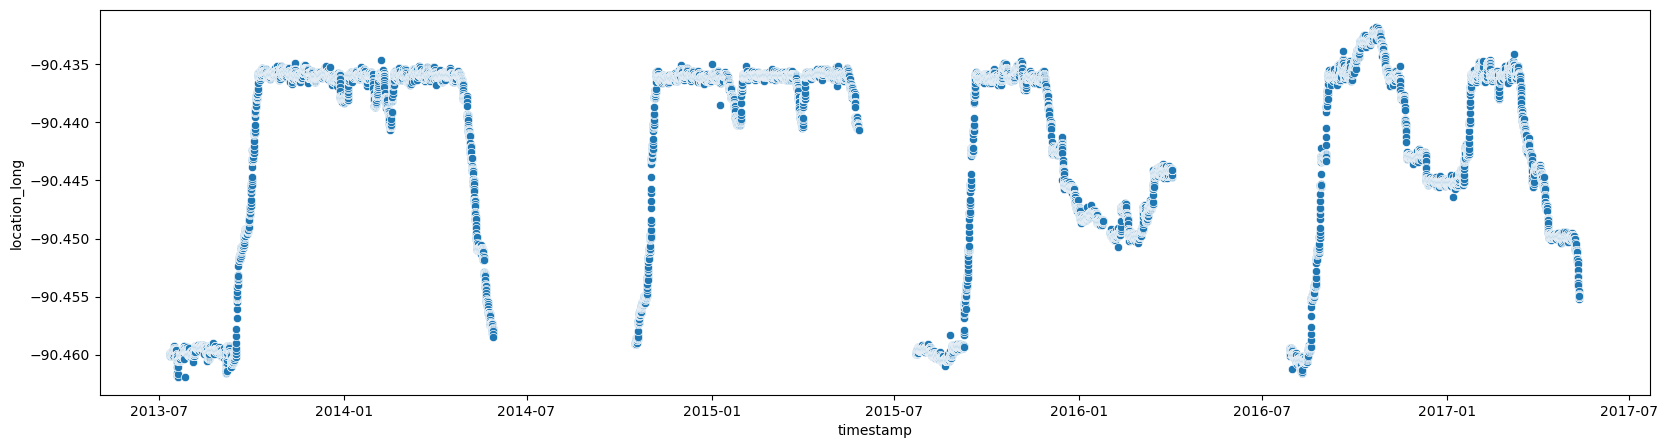

In [54]:
invidual_lat_long("Chrissie", "location_long")

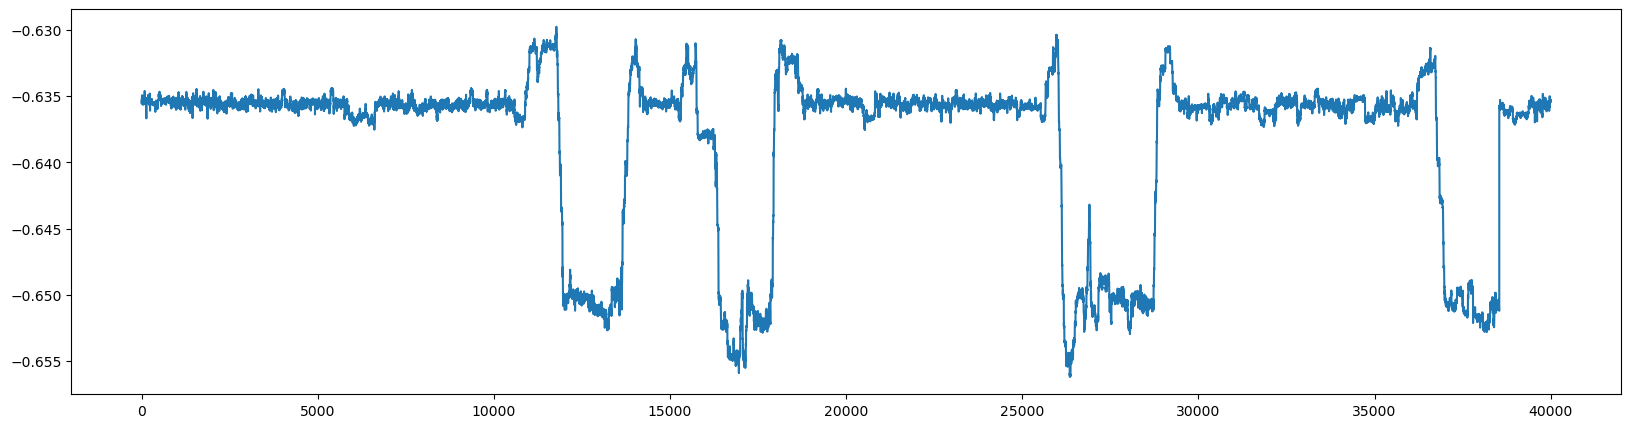

In [55]:
plt.figure(figsize = (20,5))
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
plt.plot(alison.location_lat.values)

In [56]:
import skmob
from skmob.measures.individual import maximum_distance
tortoise_max_distance = maximum_distance(tortoise_trajectory)
tortoise_max_distance

100%|██████████| 96/96 [00:06<00:00, 13.72it/s]


,uid,maximum_distance
0,Alison,3.781776
1,Andrea,1.173420
2,Andres,0.711277
3,Anne,0.688293
4,Bill,1.053307
5,Birgit,0.368320
6,Carolina,1.518231
7,Charles,0.382068
8,Chica,0.560945
9,Chrissie,3.249870


In [57]:
from skmob.measures.individual import number_of_locations
tortoise_num_locations = number_of_locations(tortoise_trajectory)
tortoise_num_locations

100%|██████████| 96/96 [00:19<00:00,  4.96it/s]


,uid,number_of_locations
0,Alison,40002
1,Andrea,1519
2,Andres,3739
3,Anne,41109
4,Bill,1814
5,Birgit,28311
6,Carolina,45354
7,Charles,9178
8,Chica,1754
9,Chrissie,25349


In [58]:
alison_trajectory = skmob.TrajDataFrame(alison, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)
print(alison_trajectory.head())

         event_id               timestamp                    timestamp_UTC  \
1290187  46119277 2010-09-17 17:01:25.998 2010-09-17 17:01:25.998000+00:00   
1290188  46119278 2010-09-17 18:00:58.001 2010-09-17 18:00:58.001000+00:00   
1290189  46119279 2010-09-17 19:00:56.001 2010-09-17 19:00:56.001000+00:00   
1290190  46119280 2010-09-17 20:00:29.000        2010-09-17 20:00:29+00:00   
1290191  46119281 2010-09-17 21:00:56.000        2010-09-17 21:00:56+00:00   

                                datetime  minute_diff        lng       lat  \
1290187 2010-09-17 10:01:25.998000-07:00            0 -90.241889 -0.635366   
1290188 2010-09-17 11:00:58.001000-07:00           59 -90.242230 -0.635563   
1290189 2010-09-17 12:00:56.001000-07:00           59 -90.242210 -0.635515   
1290190        2010-09-17 13:00:29-07:00           59 -90.242227 -0.635356   
1290191        2010-09-17 14:00:56-07:00           60 -90.242101 -0.635276   

         eobs_temperature  ground_speed  heading  height_above

<Axes: >

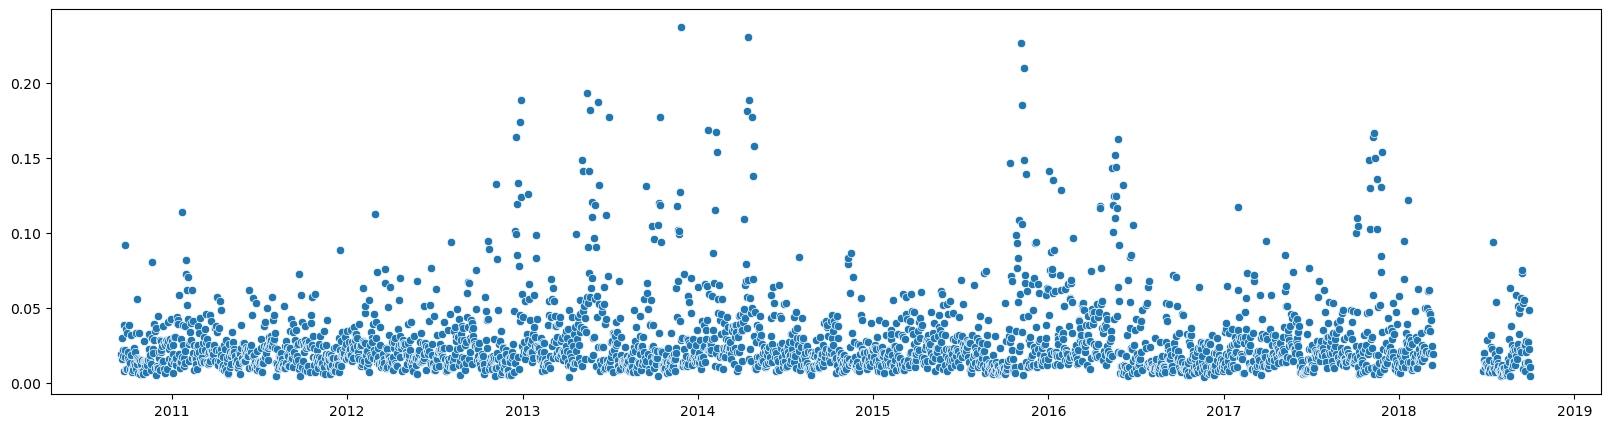

In [59]:
from skmob.measures.individual import radius_of_gyration
alison_rog = []
date_list = []
for date in alison.date.unique():
    date_list.append(date)
    #rog = radius_of_gyration(alison_trajectory[alison_trajectory["date"] == date],show_progress=False)["radius_of_gyration"][0]
    #alison_rog.append(rog)
    alison_rog.append(radius_of_gyration(alison_trajectory[alison_trajectory["date"] == date], show_progress=False)["radius_of_gyration"])
plt.figure(figsize = (20,5))
sns.scatterplot(x=date_list, y=np.array(alison_rog).ravel())

<Axes: xlabel='timestamp_local', ylabel='location_long'>

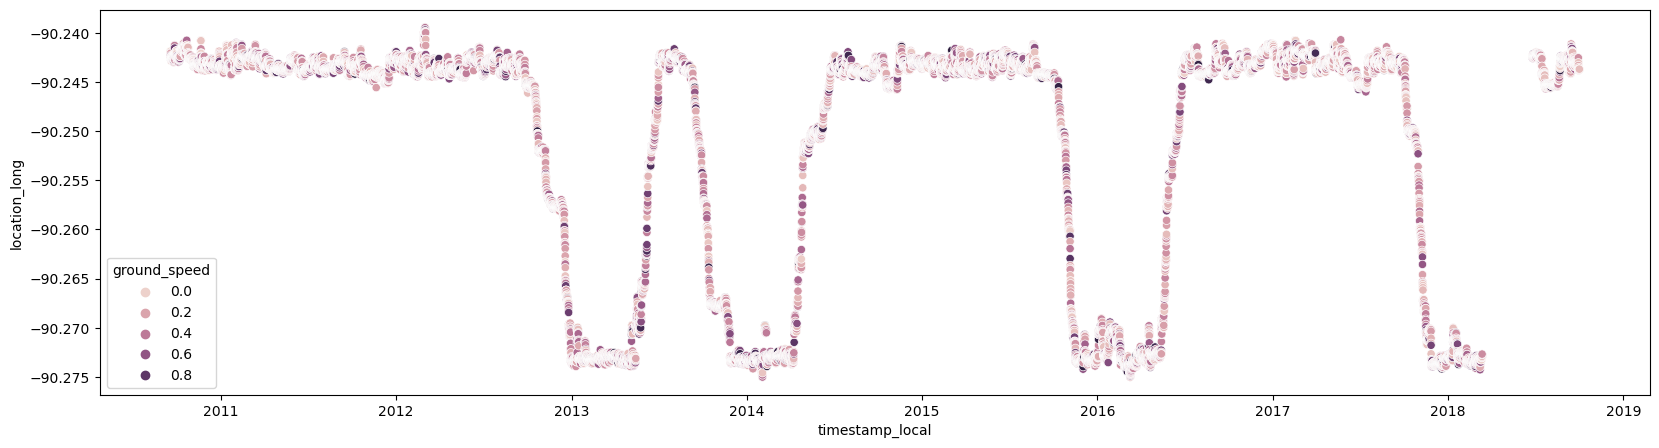

In [60]:
plt.figure(figsize = (20,5))
alison = tortoise.query("individual_local_identifier == 'Alison' and ground_speed <1") # ground_speed unit is meters per second
sns.scatterplot(alison, x = "timestamp_local", y="location_long", hue="ground_speed")


<Axes: xlabel='timestamp_local', ylabel='ground_speed'>

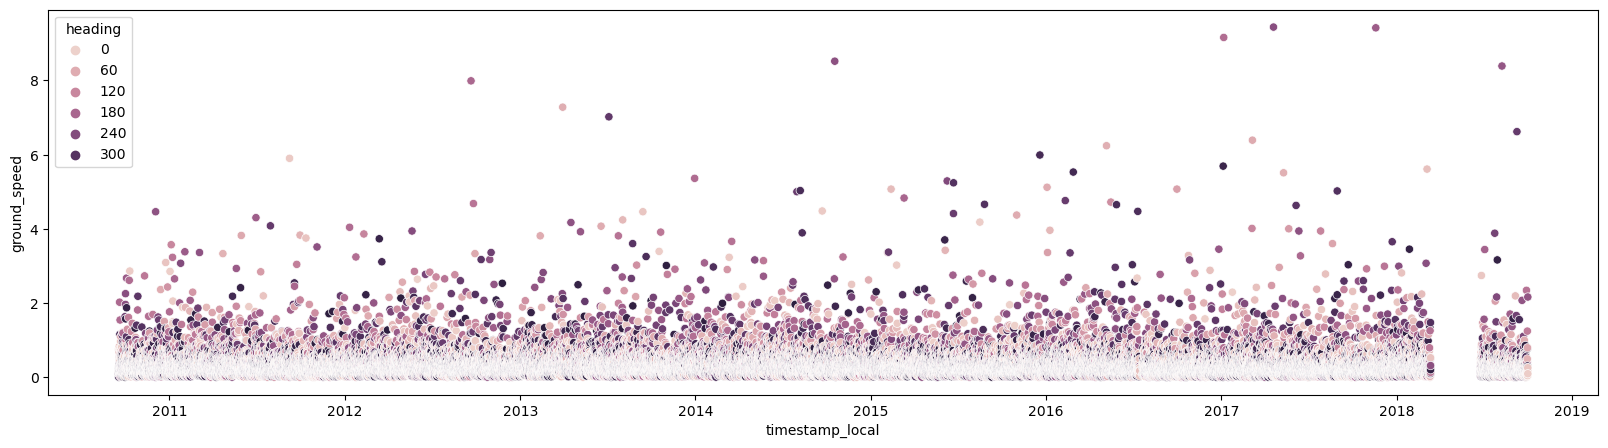

In [61]:
plt.figure(figsize = (20,5))
temp_df = tortoise.query("individual_local_identifier == 'Alison' and ground_speed < 10") # ground_speed unit is meters per second
sns.scatterplot(temp_df, x = "timestamp_local", y="ground_speed", hue="heading")


<Axes: xlabel='timestamp_local', ylabel='ground_speed'>

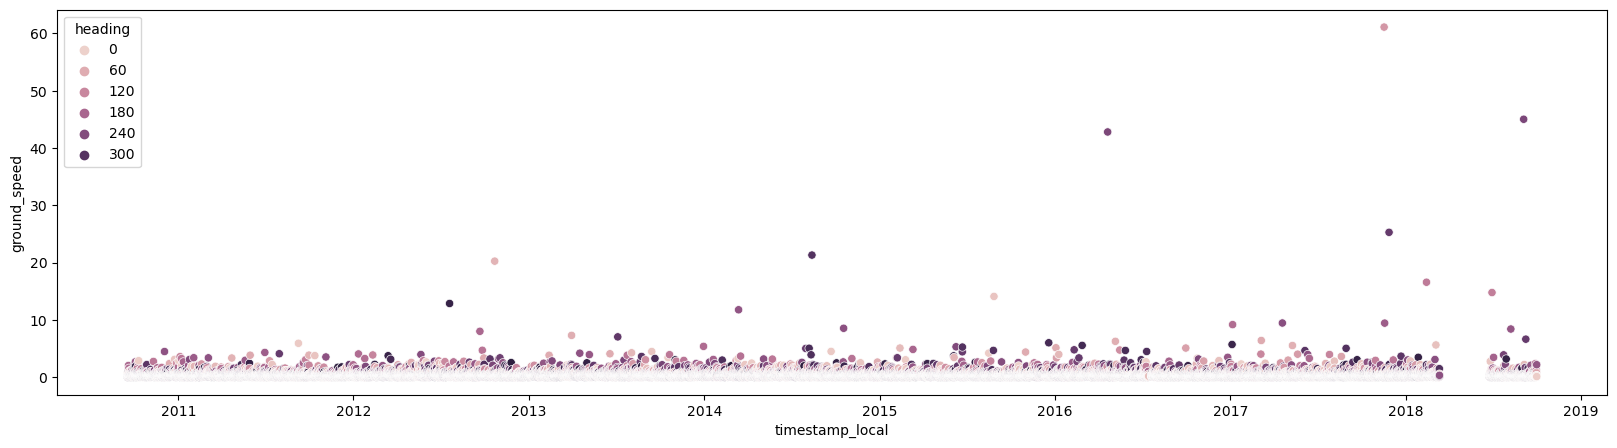

In [62]:
plt.figure(figsize = (20,5))
alison = tortoise.query("individual_local_identifier == 'Alison'") # ground_speed unit is meters per second
sns.scatterplot(alison, x = "timestamp_local", y="ground_speed", hue="heading")
